In [2]:
from dotenv import load_dotenv
import requests
import os
import pandas as pd
import time


In [ ]:

load_dotenv()

api_key =  os.environ.get("riot_api_key")

In [ ]:
import requests
from requests.adapters import HTTPAdapter
from urllib3.util.retry import Retry
import pandas as pd
from requests.adapters import HTTPAdapter


def create_session_with_retry():
    session = requests.Session()

    retries = Retry(
        backoff_factor=1,
        status_forcelist=[429, 500, 502, 503, 504],
        allowed_methods=["HEAD", "GET", "OPTIONS"],
        raise_on_status=False
    )

    # Aumente os limites de conexões
    adapter = HTTPAdapter(
        max_retries=retries,
        pool_connections=100,  # Conexões paralelas no pool
        pool_maxsize=100       # Tamanho máximo do pool
    )

    session.mount("https://", adapter)
    session.mount("http://", adapter)

    return session

# Criar sessão compartilhada
session = create_session_with_retry()

In [392]:
async def fetch_data_async(url):
    async with httpx.AsyncClient() as client:
        response = await client.get(url)
        return response

In [ ]:
# FUNCAO RANK LIST
def chall_players(key):
    link = f"https://br1.api.riotgames.com/lol/league/v4/challengerleagues/by-queue/RANKED_SOLO_5x5?api_key={key}"
    req = session.get(link)


    df = pd.DataFrame(req.json())

    normalize_df = pd.json_normalize(df['entries'])
    df = pd.concat([df.drop(columns='entries'), normalize_df], axis=1)
    df.drop(columns=["name","rank","leagueId"],axis=1,inplace=True)
    df.sort_values("leaguePoints").reset_index(drop=True,inplace=True)

    df_id = process_ids(api_key,df,"summonerId")
    df_id.rename(columns={'id': 'summonerId'}, inplace=True)
    resultado = pd.merge(df_id, df, on='summonerId', how='inner')
    return resultado

def add_puuid(key,id):
    link=f"https://br1.api.riotgames.com/lol/summoner/v4/summoners/{id}?api_key={key}"
    req = session.get(link)
    return req

def process_ids(api_key, df, column_name):
    """
    Percorre uma coluna de um DataFrame, faz as requisições para cada ID, e organiza os resultados em um DataFrame.
    """
    results = []
    i=0
    for summoner_id in df[column_name]:
        data = add_puuid(api_key, summoner_id).json()
        if data:
            results.append(data)  
            
            print(data)
    result_df = pd.DataFrame(results)
    return result_df

In [377]:
def player_match_data(df , puuid,js):

    metadata= js["metadata"]
    info = js["info"]
    ###################
   
    participants = metadata["participants"]


    players = info["participants"]

    player= players[participants.index(puuid)]
    chal= player["challenges"]  
    data = {
        "match_id": metadata["matchId"],
        "game_duration": info["gameDuration"],
        "result": info["endOfGameResult"],
        "champion_id": player["championId"],
        "champion_name": player["championName"],
        "deaths": player["deaths"],
        "control_wards_placed": player["detectorWardsPlaced"],
        "enemy_missing_pings": player["enemyMissingPings"],
        "enemy_vision_pings": player["enemyVisionPings"],
        "first_blood_kill": player["firstBloodKill"],
        "first_blood_assist": player["firstBloodAssist"],
        "surrender": player["gameEndedInSurrender"],
        "early_surrender": player["gameEndedInEarlySurrender"],
        "gold_spent": player["goldSpent"],
        "role": player["teamPosition"],
        "item0": player["item0"],
        "item1": player["item1"],
        "item2": player["item2"],
        "item3": player["item3"],
        "item4": player["item4"],
        "item5": player["item5"],
        "item6": player["item6"],
        "largest_killing_spree": player["largestKillingSpree"],
        "kills": player["kills"],
        "neutral_minions_killed": player["neutralMinionsKilled"],
        "stolen_objects": player["objectivesStolen"],
        "stolen_objects_assist": player["objectivesStolenAssists"],
        "pentakills": player["pentaKills"],
        "puuid": player["puuid"],
        "summoner_name": player["summonerName"],
        "summoner_level": player["summonerLevel"],
        "team_id": player["teamId"],
        "total_damage_dealt": player["totalDamageDealtToChampions"],
        "total_damage_taken": player["totalDamageTaken"],
        "jungle_stole": player["totalEnemyJungleMinionsKilled"],
        "total_heal": player["totalHeal"],
        "total_heal_teammate": player["totalHealsOnTeammates"],
        "turret_kills": player["turretKills"],
        "vision_score": player["visionScore"],
        "wards_killed": player["wardsKilled"],
        "wards_placed": player["wardsPlaced"],
        "win": player["win"],
        "assists": player["assists"],
        "buff_stolen": chal["buffsStolen"],
        "first_turret": chal["firstTurretKilled"],
        "kda": chal["kda"],
        "kills_near_enemy_turrets": chal["killsNearEnemyTurret"],
        "kills_under_turret": chal["killsUnderOwnTurret"],
        "multi_kills": chal["multikills"],
        "outnumbered_kills": chal["outnumberedKills"],
        "save_ally": chal["saveAllyFromDeath"],
        "solo_kills": chal["soloKills"],
        "vision_per_min": chal["visionScorePerMinute"],
    }

    # Convertendo os dados em um DataFrame
    data = pd.DataFrame([data])
    df_res=pd.concat([df,data],ignore_index=True)
    # Exibindo o DataFrame
    return df_res

In [451]:
#MATCH-V5
def match_hist(puuid , key):
    req = session.get(f"https://americas.api.riotgames.com/lol/match/v5/matches/by-puuid/{puuid}/ids?queue=420&type=ranked&start=0&count=100&api_key={api_key}")
    print(req.status_code)
    print("match_hist")
    return list(req.json())

def match_request(matchId,api_key):
    req = session.get(f"https://americas.api.riotgames.com/lol/match/v5/matches/{matchId}?api_key={api_key}")
    print(req.status_code)
    print("match_request")
    return req.json()

def df_match_player(data,api_key):
    df= pd.DataFrame()
    for id in data["puuid"]:
        list= match_hist(id,api_key)
        for match in list:
            js = match_request(match,api_key)
            df= player_match_data(df,id,js)
    return df
    

In [ ]:
df_final = chall_players(api_key)



In [ ]:
#df_final.to_csv("df_players.csv")

In [ ]:
#Coleta todos os dados.
data_players_final = df_match_player(df_final,api_key)

In [456]:
data_players_final.to_csv("players_data_final.csv")

In [417]:
data_players.to_csv("players_data.csv")

In [450]:
df_filtered[["summoner_name","puuid","role","kda","champion_name","kills","item0"]].head(11)

,summoner_name,puuid,role,kda,champion_name,kills,item0
0,random gap,1xHcB3dGcWANeBntLEWlfxAHR9VPglTSf1qV_TquVnaleV...,TOP,2.000000,Aurora,4,1058
1,random gap,1xHcB3dGcWANeBntLEWlfxAHR9VPglTSf1qV_TquVnaleV...,MIDDLE,20.000000,Aurora,12,3089
2,random gap,1xHcB3dGcWANeBntLEWlfxAHR9VPglTSf1qV_TquVnaleV...,MIDDLE,7.500000,Aurora,9,3135
3,random gap,1xHcB3dGcWANeBntLEWlfxAHR9VPglTSf1qV_TquVnaleV...,MIDDLE,4.333333,Akshan,10,3033
4,random gap,1xHcB3dGcWANeBntLEWlfxAHR9VPglTSf1qV_TquVnaleV...,MIDDLE,6.000000,Aurora,8,1056


In [449]:
df_filtered = data_players[data_players['puuid'] == '1xHcB3dGcWANeBntLEWlfxAHR9VPglTSf1qV_TquVnaleVjhdYso2U0Z8T6bHEsUCEQNdDppGEpQ7A']
df_filtered

,match_id,game_duration,result,champion_id,champion_name,deaths,control_wards_placed,enemy_missing_pings,enemy_vision_pings,first_blood_kill,...,buff_stolen,first_turret,kda,kills_near_enemy_turrets,kills_under_turret,multi_kills,outnumbered_kills,save_ally,solo_kills,vision_per_min
0,BR1_3050161105,1626,GameComplete,893,Aurora,5,2,10,13,False,...,0,1,2.000000,2,0,0,1,0,2,0.846804
1,BR1_3049761538,1450,GameComplete,893,Aurora,0,2,17,4,False,...,0,1,20.000000,1,2,1,1,0,1,0.522749
2,BR1_3043274053,1855,GameComplete,893,Aurora,2,3,11,9,False,...,0,1,7.500000,3,1,0,3,0,3,0.707138
3,BR1_3043251739,2381,GameComplete,166,Akshan,3,1,21,9,False,...,1,1,4.333333,2,0,4,1,0,1,1.231529
4,BR1_3042855360,1470,GameComplete,893,Aurora,2,2,10,11,False,...,0,0,6.000000,0,0,2,0,0,1,0.746359


# Analisys

In [425]:
data_players.columns

Index(['match_id', 'game_duration', 'result', 'champion_id', 'champion_name',
       'deaths', 'control_wards_placed', 'enemy_missing_pings',
       'enemy_vision_pings', 'first_blood_kill', 'first_blood_assist',
       'surrender', 'early_surrender', 'gold_spent', 'role', 'item0', 'item1',
       'item2', 'item3', 'item4', 'item5', 'item6', 'largest_killing_spree',
       'kills', 'neutral_minions_killed', 'stolen_objects',
       'stolen_objects_assist', 'pentakills', 'puuid', 'summoner_name',
       'summoner_level', 'team_id', 'total_damage_dealt', 'total_damage_taken',
       'jungle_stole', 'total_heal', 'total_heal_teammate', 'turret_kills',
       'vision_score', 'wards_killed', 'wards_placed', 'win', 'assists',
       'buff_stolen', 'first_turret', 'kda', 'kills_near_enemy_turrets',
       'kills_under_turret', 'multi_kills', 'outnumbered_kills', 'save_ally',
       'solo_kills', 'vision_per_min'],
      dtype='object')

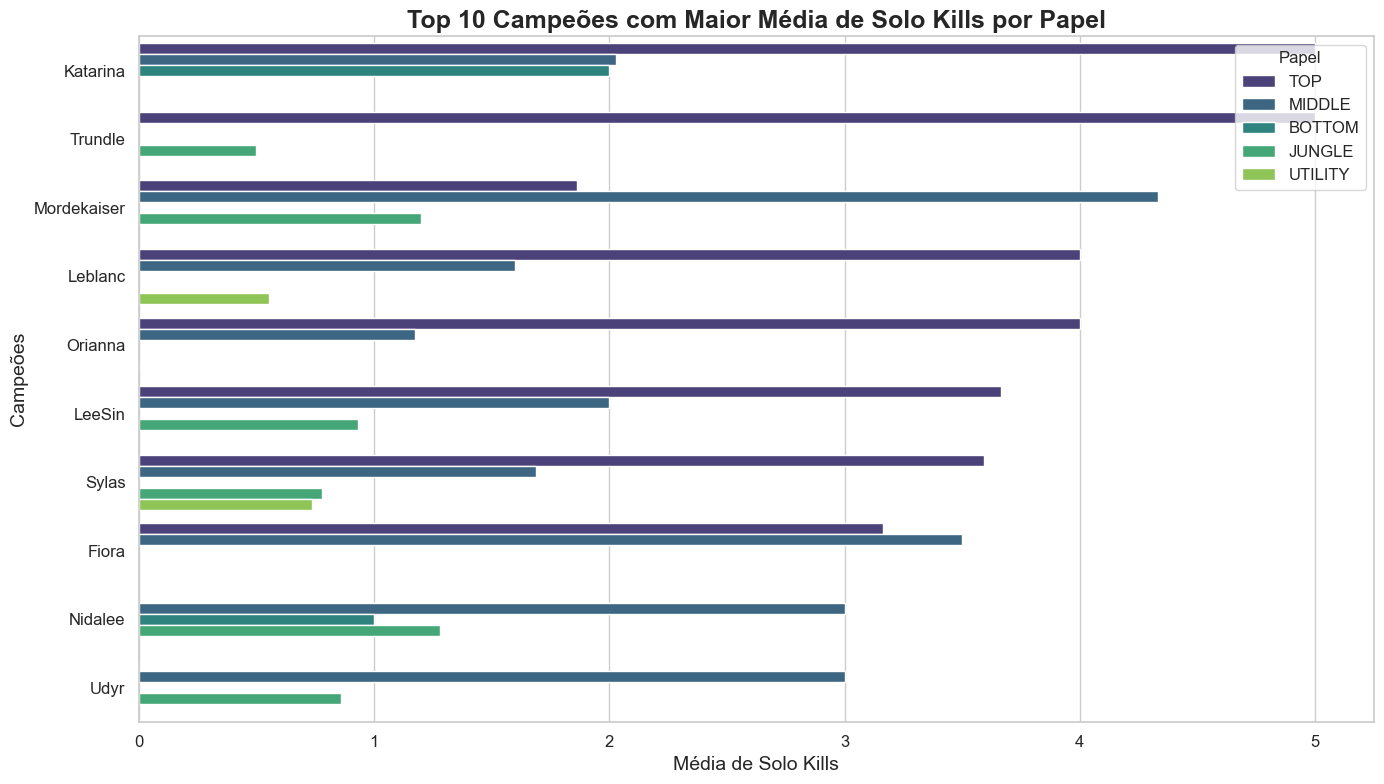

In [457]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Exemplo: carregando o dataset
# Substitua 'seu_dataset.csv' pelo nome do arquivo com seus dados
df = pd.read_csv('players_data_final.csv')

# Agrupando os dados por 'champion_name' e 'role', calculando a média de 'solo_kills'
solo_kills_avg = (
    df.groupby(['champion_name', 'role'])['solo_kills']
    .mean()
    .reset_index()
    .sort_values(by='solo_kills', ascending=False)
)

# Selecionando os 10 campeões com mais solo kills
top_10_champions = solo_kills_avg['champion_name'].unique()[:10]
top_10_data = solo_kills_avg[solo_kills_avg['champion_name'].isin(top_10_champions)]

# Configurando o estilo do gráfico
sns.set_theme(style='whitegrid')

# Tamanho do gráfico
plt.figure(figsize=(14, 8))

# Criando o gráfico com Seaborn
sns.barplot(
    data=top_10_data,
    x='solo_kills',
    y='champion_name',
    hue='role',  # Cor por papel
    palette='viridis'
)

# Títulos e rótulos
plt.title('Top 10 Campeões com Maior Média de Solo Kills por Papel', fontsize=18, fontweight='bold')
plt.xlabel('Média de Solo Kills', fontsize=14)
plt.ylabel('Campeões', fontsize=14)
plt.legend(title='Papel', loc='upper right', fontsize=12, title_fontsize=12)

# Melhorando o layout
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()

# Exibindo o gráfico
plt.show()

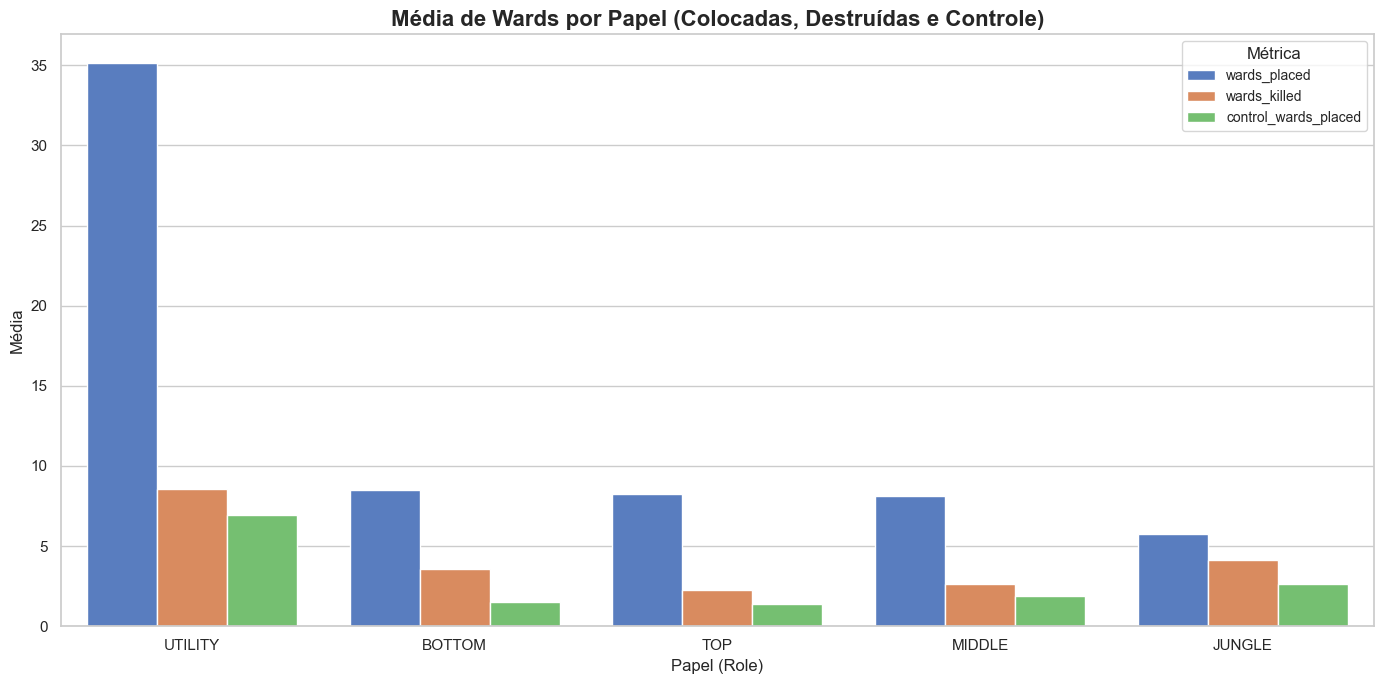

In [458]:
 #Agrupando os dados por papel (role) e calculando as médias das métricas de visão
wards_avg = (
    df.groupby('role')[['wards_placed', 'wards_killed', 'control_wards_placed']]
    .mean()
    .reset_index()
    .sort_values(by='wards_placed', ascending=False)
)

# Transformando o DataFrame para formato longo (long format) para facilitar o gráfico
wards_avg_long = pd.melt(
    wards_avg,
    id_vars='role',
    value_vars=['wards_placed', 'wards_killed', 'control_wards_placed'],
    var_name='Métrica',
    value_name='Média'
)

# Configurando o estilo do gráfico
sns.set_theme(style='whitegrid')

# Tamanho do gráfico
plt.figure(figsize=(14, 7))

# Criando o gráfico com Seaborn
sns.barplot(
    data=wards_avg_long,
    x='role',
    y='Média',
    hue='Métrica',
    palette='muted'
)

# Títulos e rótulos
plt.title('Média de Wards por Papel (Colocadas, Destruídas e Controle)', fontsize=16, fontweight='bold')
plt.xlabel('Papel (Role)', fontsize=12)
plt.ylabel('Média', fontsize=12)
plt.legend(title='Métrica', loc='upper right', fontsize=10, title_fontsize=12)

# Melhorando o layout
plt.xticks(fontsize=11)
plt.yticks(fontsize=11)
plt.tight_layout()

# Exibindo o gráfico
plt.show()

/var/folders/xc/cl991pz94vlfh_4hrlpwhgbm0000gn/T/ipykernel_23802/3459942802.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


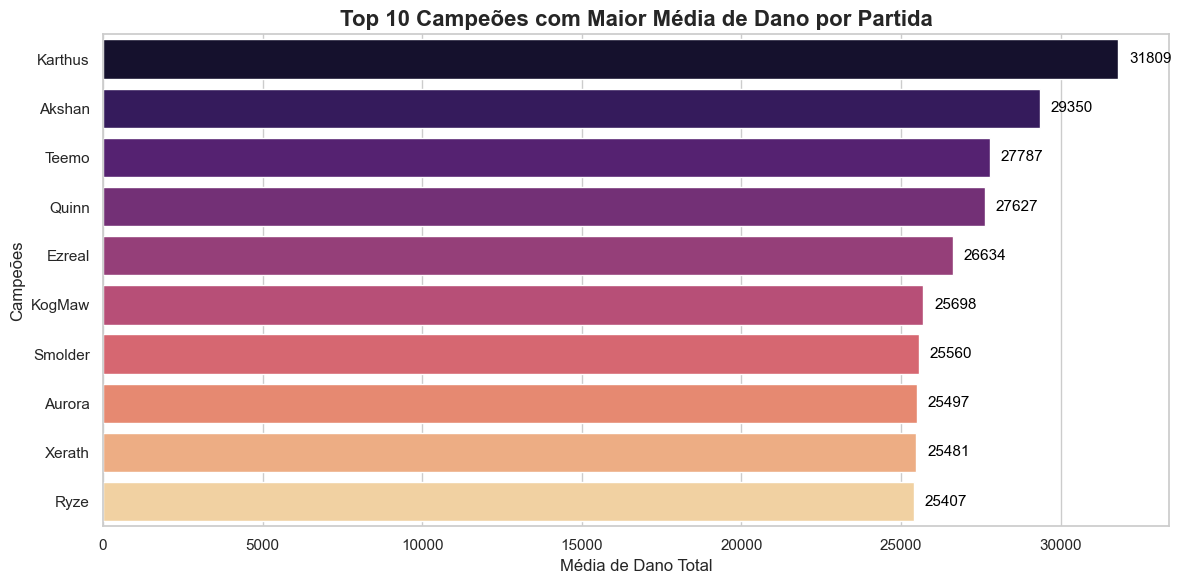

In [459]:
# Contando a quantidade de aparições de cada campeão
champion_count = df['champion_name'].value_counts().reset_index()
champion_count.columns = ['champion_name', 'count']

# Filtrando campeões que aparecem mais de 5 vezes
champion_count_filtered = champion_count[champion_count['count'] > 5]

# Filtrando o DataFrame original com base nos campeões filtrados
df_filtered = df[df['champion_name'].isin(champion_count_filtered['champion_name'])]

# Calculando a média de dano total por campeão
damage_avg = (
    df_filtered.groupby('champion_name')['total_damage_dealt']
    .mean()
    .reset_index()
    .sort_values(by='total_damage_dealt', ascending=False)
)

# Selecionando os 10 campeões com maior média de dano
top_10_damage = damage_avg.head(10)

# Configurando o estilo do gráfico
sns.set_theme(style='whitegrid')

# Tamanho do gráfico
plt.figure(figsize=(12, 6))

# Criando o gráfico com Seaborn
ax = sns.barplot(
    data=top_10_damage,
    x='total_damage_dealt',
    y='champion_name',
    palette='magma'
)

# Adicionando valores numéricos ao lado das barras
for p in ax.patches:
    ax.annotate(
        f'{p.get_width():.0f}',
        (p.get_width() + 1000, p.get_y() + p.get_height() / 2),
        ha='center',
        va='center',
        fontsize=11,
        color='black'
    )

# Títulos e rótulos
plt.title('Top 10 Campeões com Maior Média de Dano por Partida', fontsize=16, fontweight='bold')
plt.xlabel('Média de Dano Total', fontsize=12)
plt.ylabel('Campeões', fontsize=12)

# Melhorando o layout
plt.xticks(fontsize=11)
plt.yticks(fontsize=11)
plt.tight_layout()

# Exibindo o gráfico
plt.show()

/var/folders/xc/cl991pz94vlfh_4hrlpwhgbm0000gn/T/ipykernel_23802/3874246297.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


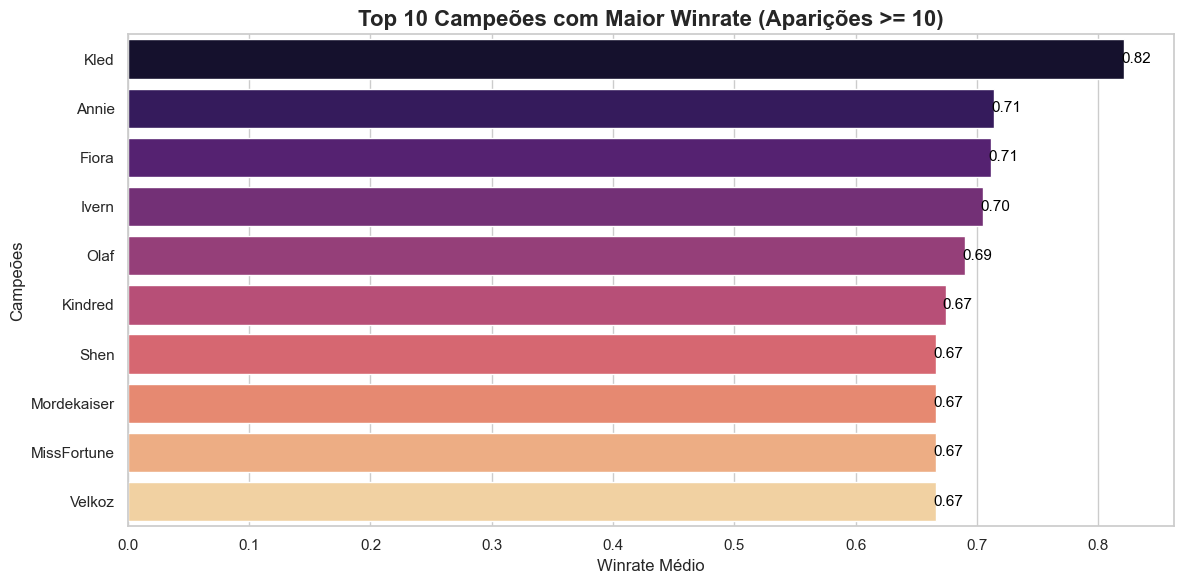

In [460]:
# Contando a quantidade de aparições de cada campeão
champion_count = df['champion_name'].value_counts().reset_index()
champion_count.columns = ['champion_name', 'count']

# Filtrando campeões que aparecem 10 ou mais vezes
champion_count_filtered = champion_count[champion_count['count'] >= 10]

# Filtrando o DataFrame original com base nos campeões filtrados
df_filtered = df[df['champion_name'].isin(champion_count_filtered['champion_name'])]

# Calculando o winrate médio por campeão (winrate = vitórias / jogos)
winrate_avg = (
    df_filtered.groupby('champion_name')['win']
    .mean()
    .reset_index()
    .sort_values(by='win', ascending=False)
)

# Selecionando os 10 campeões com maior winrate
top_10_winrate = winrate_avg.head(10)

# Configurando o estilo do gráfico
sns.set_theme(style='whitegrid')

# Tamanho do gráfico
plt.figure(figsize=(12, 6))

# Criando o gráfico com Seaborn
ax = sns.barplot(
    data=top_10_winrate,
    x='win',
    y='champion_name',
    palette='magma'
)

# Adicionando valores numéricos ao lado das barras
for p in ax.patches:
    ax.annotate(
        f'{p.get_width():.2f}',
        (p.get_width() + 0.01, p.get_y() + p.get_height() / 2),
        ha='center',
        va='center',
        fontsize=11,
        color='black'
    )

# Títulos e rótulos
plt.title('Top 10 Campeões com Maior Winrate (Aparições >= 10)', fontsize=16, fontweight='bold')
plt.xlabel('Winrate Médio', fontsize=12)
plt.ylabel('Campeões', fontsize=12)

# Melhorando o layout
plt.xticks(fontsize=11)
plt.yticks(fontsize=11)
plt.tight_layout()

# Exibindo o gráfico
plt.show()

/var/folders/xc/cl991pz94vlfh_4hrlpwhgbm0000gn/T/ipykernel_23802/3123470190.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


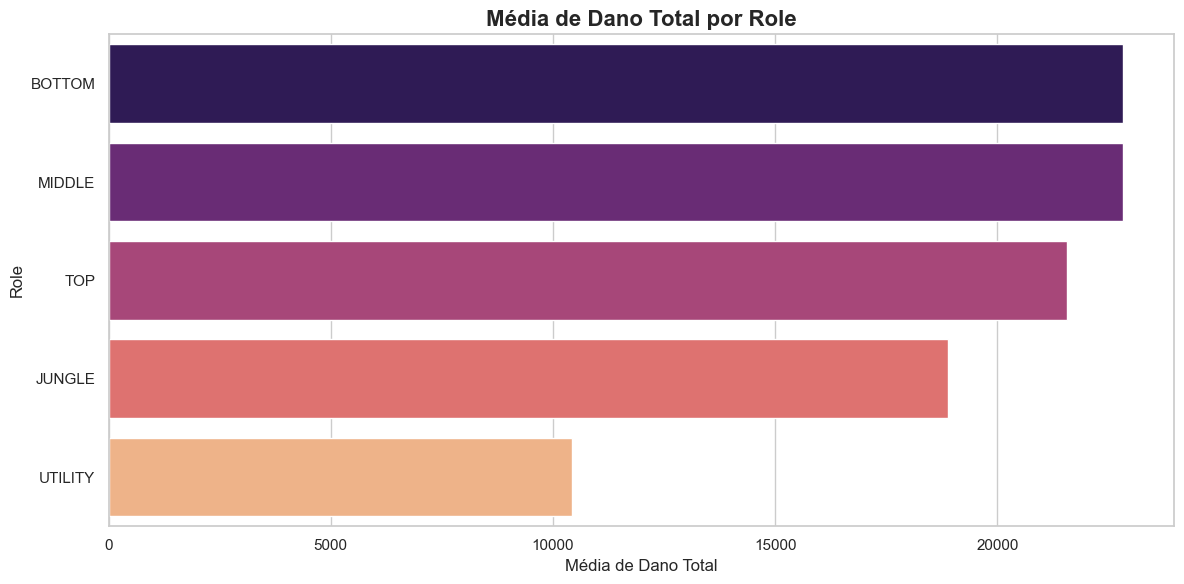

In [461]:
damage_avg_role = (
    df.groupby('role')['total_damage_dealt']
    .mean()
    .reset_index()
    .sort_values(by='total_damage_dealt', ascending=False)
)

# Configurando o estilo do gráfico
sns.set_theme(style='whitegrid')

# Tamanho do gráfico
plt.figure(figsize=(12, 6))

# Criando o gráfico com Seaborn
sns.barplot(
    data=damage_avg_role,
    x='total_damage_dealt',
    y='role',
    palette='magma'
)

# Títulos e rótulos
plt.title('Média de Dano Total por Role', fontsize=16, fontweight='bold')
plt.xlabel('Média de Dano Total', fontsize=12)
plt.ylabel('Role', fontsize=12)

# Melhorando o layout
plt.xticks(fontsize=11)
plt.yticks(fontsize=11)
plt.tight_layout()

# Exibindo o gráfico
plt.show()

In [463]:
df.columns

Index(['Unnamed: 0', 'match_id', 'game_duration', 'result', 'champion_id',
       'champion_name', 'deaths', 'control_wards_placed',
       'enemy_missing_pings', 'enemy_vision_pings', 'first_blood_kill',
       'first_blood_assist', 'surrender', 'early_surrender', 'gold_spent',
       'role', 'item0', 'item1', 'item2', 'item3', 'item4', 'item5', 'item6',
       'largest_killing_spree', 'kills', 'neutral_minions_killed',
       'stolen_objects', 'stolen_objects_assist', 'pentakills', 'puuid',
       'summoner_name', 'summoner_level', 'team_id', 'total_damage_dealt',
       'total_damage_taken', 'jungle_stole', 'total_heal',
       'total_heal_teammate', 'turret_kills', 'vision_score', 'wards_killed',
       'wards_placed', 'win', 'assists', 'buff_stolen', 'first_turret', 'kda',
       'kills_near_enemy_turrets', 'kills_under_turret', 'multi_kills',
       'outnumbered_kills', 'save_ally', 'solo_kills', 'vision_per_min'],
      dtype='object')

/var/folders/xc/cl991pz94vlfh_4hrlpwhgbm0000gn/T/ipykernel_23802/458248282.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


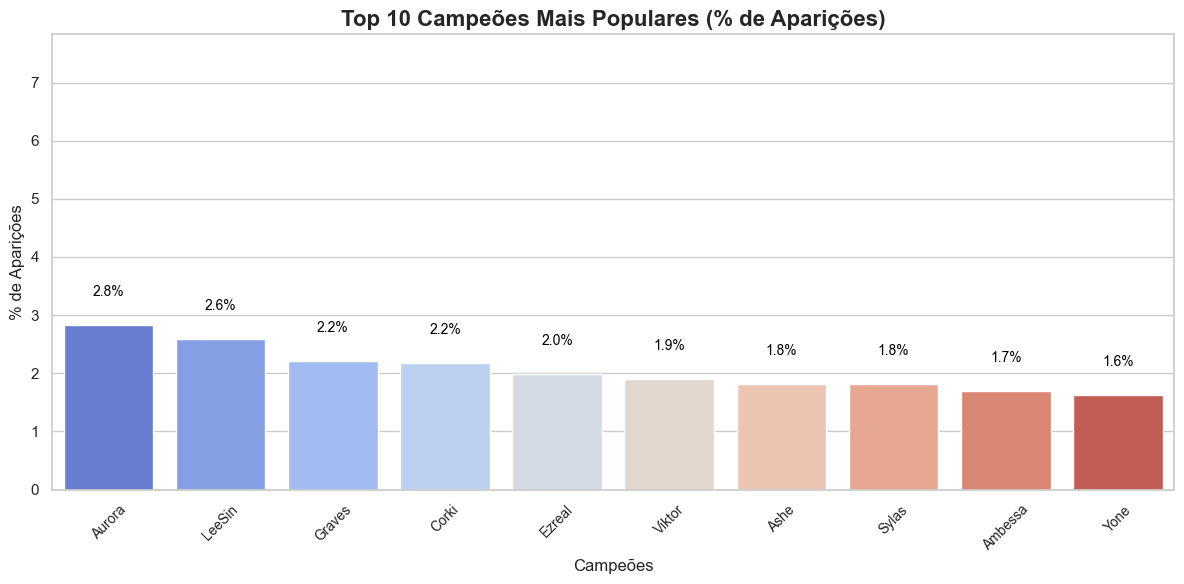

In [467]:
total_partidas = df['match_id'].nunique()  # Número total de partidas
campeoes_populares = df['champion_name'].value_counts(normalize=True).head(10) * 100  # Porcentagem

# Converter para DataFrame para plotagem
campeoes_df = campeoes_populares.reset_index()
campeoes_df.columns = ['Champion', 'Percentage']

# Configurar o estilo do gráfico com Seaborn
sns.set_theme(style="whitegrid")
plt.figure(figsize=(12, 6))

# Criar o gráfico de barras
ax = sns.barplot(
    x='Champion', 
    y='Percentage', 
    data=campeoes_df, 
    palette="coolwarm"
)

# Adicionar os valores (porcentagens) acima de cada barra
for index, row in campeoes_df.iterrows():
    ax.text(index, row['Percentage'] + 0.5, f"{row['Percentage']:.1f}%", ha='center', fontsize=10, color='black')

# Personalizar o gráfico
plt.title('Top 10 Campeões Mais Populares (% de Aparições)', fontsize=16, weight='bold')
plt.xlabel('Campeões', fontsize=12)
plt.ylabel('% de Aparições', fontsize=12)
plt.xticks(rotation=45, fontsize=10)
plt.ylim(0, campeoes_df['Percentage'].max() + 5)  # Ajustar o limite do eixo Y para evitar sobreposição

# Mostrar o gráfico
plt.tight_layout()
plt.show()

In [ ]:
partidas_por_jogador = df.groupby('puuid')['match_id'].nunique()

# Contar o número de partidas por jogador e campeão
partidas_por_jogador_e_campeao = df.groupby(['puuid', 'champion_name'])['match_id'].nunique()

# Calcular a porcentagem de partidas com cada campeão para cada jogador
percentuais = (partidas_por_jogador_e_campeao / partidas_por_jogador) * 100

# Filtrar jogadores mono champion (60% ou mais das partidas com o mesmo campeão)
mono_champions = percentuais[percentuais >= 60].reset_index()
mono_champions.columns = ['puuid', 'champion_name', 'percentage']

# Adicionar os nomes dos jogadores
mono_champions = mono_champions.merge(
    df[['puuid', 'summoner_name']].drop_duplicates(), 
    on='puuid', 
    how='left'
)

# Selecionar as colunas relevantes
mono_champions_df = mono_champions[['puuid', 'summoner_name', 'champion_name', 'percentage']]

# Ordenar pelo maior percentual de partidas
mono_champions_df = mono_champions_df.sort_values(by='percentage', ascending=False).reset_index(drop=True)

# Exibir o DataFrame
mono_champions_df

,puuid,summoner_name,champion_name,percentage
0,dM1k-jAMR9ppLhdrwl6HIMCrVtrMCL67vAIF_olBnggAor...,Traйs Lover,AurelionSol,97.0
1,wUUvpSXKYGlspMxAePwFSWsGQsjIppAqRoKkrAZyFurqY7...,Raazgriz,Chogath,96.0
2,zoUc-BNm-JV6gNOIbmAQY7mOHw1dXvkux6vH8flFLI3baU...,GOD KILLER,Pantheon,95.0
3,A8CEazz2japTyCUL1A1rnHP39WFnnWKmWa4dqpUsK_WuWs...,Raivern,Ivern,93.0
4,c9ZYWQgOJNhM-MAGI_FpxvwhLpKq1UVtIOR1MnSfMIBTfm...,Mister,Vladimir,93.0
5,Hi5n73Qg_ApsdVh2vmfnTUVqnIoKjGEMiztZgMzpi95tLz...,Zac ou Dodge,Zac,91.0
6,-UKFdTmX9E2jAohKVBStEvs1JYNfChMynigzW9UhTP0PUf...,The HalloweeN,Udyr,90.0
7,IPbG-NwEwvsmTBjXa79bQJbUMujTBMwU-vkv6wBTKXiSPO...,DU REALLY MAD,Gangplank,90.0
8,XReBXZCKYrtT4RctqbF_j5glomK6TqXq-xGyIrRzgp4qoC...,Vritra Seris,Taric,89.0
9,t13s8WSGvG1zfpY2qWqmP9KXQ6kv9kjGq75E8vOtjxG8i5...,Sacrógrito,Gangplank,88.0


In [5]:
df=pd.read_csv("players_data_final.csv")

In [8]:
# Contar o número de partidas por jogador
partidas_por_jogador = df.groupby('puuid')['match_id'].nunique()

# Contar o número de partidas por jogador e campeão
partidas_por_jogador_e_campeao = df.groupby(['puuid', 'champion_name'])['match_id'].nunique()

# Calcular a porcentagem de partidas com cada campeão para cada jogador
percentuais = (partidas_por_jogador_e_campeao / partidas_por_jogador) * 100

# Filtrar jogadores mono champion (60% ou mais das partidas com o mesmo campeão)
mono_champions = percentuais[percentuais >= 60].reset_index()
mono_champions.columns = ['puuid', 'champion_name', 'percentage']

# Adicionar os nomes dos jogadores
mono_champions = mono_champions.merge(
    df[['puuid', 'summoner_name']].drop_duplicates(), 
    on='puuid', 
    how='left'
)

# Calcular o win rate para os campeões monocampeões
# Filtrar as partidas apenas dos campeões principais de cada jogador
matches_mono = df.merge(mono_champions, on=['puuid', 'champion_name'], how='inner')

# Contar o número de vitórias para cada jogador com seu campeão principal
vitorias = matches_mono[matches_mono['win'] == True].groupby(['puuid', 'champion_name'])['match_id'].nunique()

# Contar o número total de partidas para os monocampeões
partidas_totais = matches_mono.groupby(['puuid', 'champion_name'])['match_id'].nunique()

# Calcular o win rate
win_rate = (vitorias / partidas_totais) * 100
win_rate = win_rate.reset_index()
win_rate.columns = ['puuid', 'champion_name', 'win_rate']

# Adicionar o win rate ao DataFrame de monocampeões
mono_champions_df = mono_champions.merge(win_rate, on=['puuid', 'champion_name'], how='left')

# Selecionar as colunas relevantes
mono_champions_df = mono_champions_df[['puuid', 'summoner_name', 'champion_name', 'percentage', 'win_rate']]

# Ordenar pelo maior percentual de partidas
mono_champions_df = mono_champions_df.sort_values(by='percentage', ascending=False).reset_index(drop=True)

# Exibir o DataFrame final
mono_champions_df.sort_values('win_rate',ascending=False)

,puuid,summoner_name,champion_name,percentage,win_rate
32,KatCspi5BYq_d3hEUtSeAunC8iYiKH4gmL2lkGpZOQgNyM...,Cisne de GeIo,Kindred,70.0,78.571429
26,m_qVQNHVSGIGtXuBWtG8aJamP8Nf6NWxGcRcmC9KYQwc6b...,tethering,Zeri,76.0,77.631579
3,A8CEazz2japTyCUL1A1rnHP39WFnnWKmWa4dqpUsK_WuWs...,Raivern,Ivern,93.0,70.967742
21,38l87Mepu1OFikRHveseHIhvuOoPfcJ9FidfJjn_2HcNIs...,ShaQuinn ONilah,Swain,77.0,70.129870
23,wM8fAu3s4HjoLCJz_6_mhn1wVyzwmWXI-M07b563rk0l5a...,Brunox1001,Zac,76.0,69.736842
40,igmxyXo2bIL5DKLn6-HG612ATNj58VvItJhHxPSE-SaRxb...,Jungle v2,JarvanIV,60.0,68.333333
15,7h9xC57VuWBMVXT_pa2YdWsXRvzigztBW0JbkZwvw4aUWu...,berg,Darius,82.0,67.073171
37,FuzWuubuC9q0fiTsXlPnpuoWfq66eMuvpldw0UTl9-p9lT...,two lovers,Evelynn,64.0,65.625000
11,swD6Rh144tgDViolEQn28IObUQU5r8F7dcJr-gyMbhudEM...,markin 17y,Anivia,86.0,65.116279
1,wUUvpSXKYGlspMxAePwFSWsGQsjIppAqRoKkrAZyFurqY7...,Raazgriz,Chogath,96.0,64.583333


In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

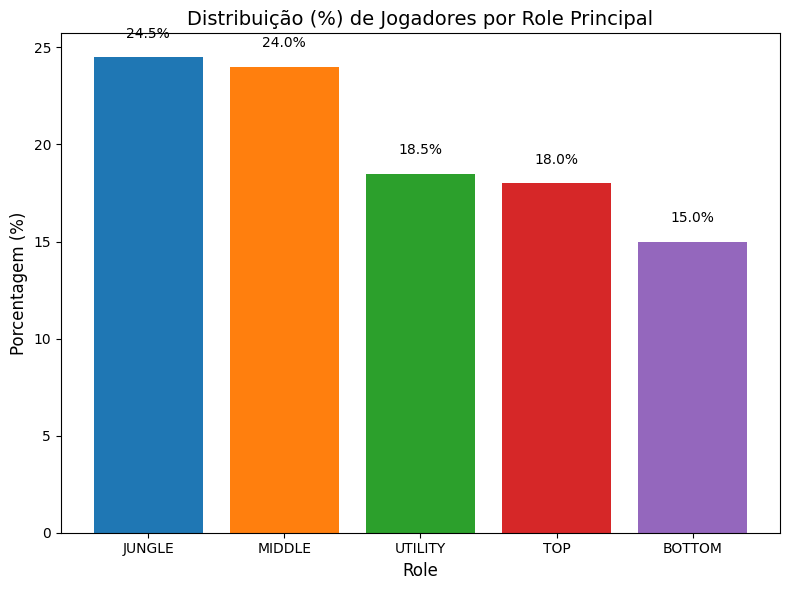

In [17]:
role_principal = (
    df.groupby(['puuid', 'role'])  # Agrupa por jogador e role
    .size()                       # Conta ocorrências
    .reset_index(name='count')    # Reseta o índice para deixar os dados planos
    .sort_values(by=['puuid', 'count'], ascending=[True, False])  # Ordena por jogador e frequência
    .drop_duplicates(subset='puuid', keep='first')  # Mantém apenas a role mais frequente por jogador
)

# Contar as roles principais de todos os jogadores
role_counts = role_principal['role'].value_counts()

# Calcular a porcentagem de cada role
role_percentages = (role_counts / role_counts.sum()) * 100

# Configurar o gráfico
plt.figure(figsize=(8, 6))
plt.bar(role_percentages.index, role_percentages, color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd'])

# Adicionar título e rótulos
plt.title('Distribuição (%) de Jogadores por Role Principal', fontsize=14)
plt.xlabel('Role', fontsize=12)
plt.ylabel('Porcentagem (%)', fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

# Adicionar valores no topo das barras
for i, value in enumerate(role_percentages):
    plt.text(i, value + 1, f'{value:.1f}%', ha='center', fontsize=10)

# Exibir o gráfico
plt.tight_layout()
plt.show()

## PREPARANDO PARA DB

In [22]:
import pandas as pd

In [23]:
df_lb= pd.read_csv("df_players.csv")
df_games = pd.read_csv("players_data_final.csv")

In [24]:
df_games.columns

Index(['Unnamed: 0', 'match_id', 'game_duration', 'result', 'champion_id',
       'champion_name', 'deaths', 'control_wards_placed',
       'enemy_missing_pings', 'enemy_vision_pings', 'first_blood_kill',
       'first_blood_assist', 'surrender', 'early_surrender', 'gold_spent',
       'role', 'item0', 'item1', 'item2', 'item3', 'item4', 'item5', 'item6',
       'largest_killing_spree', 'kills', 'neutral_minions_killed',
       'stolen_objects', 'stolen_objects_assist', 'pentakills', 'puuid',
       'summoner_name', 'summoner_level', 'team_id', 'total_damage_dealt',
       'total_damage_taken', 'jungle_stole', 'total_heal',
       'total_heal_teammate', 'turret_kills', 'vision_score', 'wards_killed',
       'wards_placed', 'win', 'assists', 'buff_stolen', 'first_turret', 'kda',
       'kills_near_enemy_turrets', 'kills_under_turret', 'multi_kills',
       'outnumbered_kills', 'save_ally', 'solo_kills', 'vision_per_min'],
      dtype='object')

In [25]:
df_lb["winrate"] =(df_lb["wins"]/(df_lb["wins"]+df_lb["losses"])).round(2)*100

In [26]:
df_lb.head()

,Unnamed: 0,summonerId,accountId,puuid,profileIconId,revisionDate,summonerLevel,tier,queue,leaguePoints,wins,losses,veteran,inactive,freshBlood,hotStreak,winrate
0,0,NjlpNEr3hMF2AYDp2eyaIEYb-Wr4y4RBFLGncVk5nNn3,30TbyJ1YjOMZ7qIUzhM2v5QvmBwgSO54_Gyn4NhHE0Y,1xHcB3dGcWANeBntLEWlfxAHR9VPglTSf1qV_TquVnaleV...,6645,1736212522320,942,CHALLENGER,RANKED_SOLO_5x5,1951,215,142,True,False,False,False,60.0
1,1,69sqzslyKFgEfUHlKP9zy11_xiOoFJGfB__zZfwhHvZX,sh2QEp6BtIjvDv8UVf7OkGM7qA82TijQDZyARywn5uE,4FRogKJxnPLAzhOl4ofD-PN7j-TjWC2LTfxx-i32XL6-qv...,536,1736239528633,69,CHALLENGER,RANKED_SOLO_5x5,1910,225,93,True,False,False,True,71.0
2,2,fOrbu2n5DtE9qy28qUrgKBaD3jxphGSZx0cuB_xlAA-5cp...,O48UBoLL6-qBmr-u8pFi69LKYm9jLLvQai5XWEX1KhI8B2...,s8qcLieY9RtxNGgJ7_cNHb7yM8Y8FJB8NBirXIGwdja2O6...,6766,1735863360000,137,CHALLENGER,RANKED_SOLO_5x5,1899,193,123,True,False,False,False,61.0
3,3,qSW5hRsT6AreMleBadsMhLE-x2jZf-CSeU5Vl-WQFbshx3s,aipFve6sMAghEcvPI_E_DrQxe42J4FJaxae7xRbfzcI5n00,lxDFRePgBH1_H4C9lD0lwixoJNYWgydXZWe-aq42qs7HV_...,3211,1736266327964,1273,CHALLENGER,RANKED_SOLO_5x5,1848,198,126,True,False,False,True,61.0
4,4,pZshtobloal0wuwCGPR__SVDAWW2H6SWI9gNZ_z_6ePTzPU,yw2JCjoCEEStEYkOLc76rAFMQc91crI0O7tWK4wyDyaLBl8,JhQ8zU4LD8LqD7pG_CxmrU_yqpOvrG6sSUZulZnDBfyP73...,5709,1736263540508,148,CHALLENGER,RANKED_SOLO_5x5,1795,189,120,True,False,False,False,61.0


In [27]:
import pandas as pd

result_df = (
    df_games.groupby('puuid')
    .agg(
        enemy_missing_pings_mean=('enemy_missing_pings', 'mean'),
        game_duration_mean=('game_duration', 'mean'),
        deaths_mean=('deaths', 'mean'),
        role_most_played=('role', lambda x: x.value_counts().idxmax()),
        champion_usage=('champion_name', lambda x: x.value_counts().to_dict()),
    )
    .reset_index()
)

result_df['top1_champion'] = result_df['champion_usage'].apply(lambda x: list(x.keys())[0] if len(x) > 0 else None)
result_df['top2_champion'] = result_df['champion_usage'].apply(lambda x: list(x.keys())[1] if len(x) > 1 else None)
result_df['top3_champion'] = result_df['champion_usage'].apply(lambda x: list(x.keys())[2] if len(x) > 2 else None)

# Verificar se o jogador é monochampion
def is_monochampion(champion_usage):
    total_matches = sum(champion_usage.values())
    for champ, count in champion_usage.items():
        if count / total_matches > 0.6:
            return champ
    return False

result_df['monochampion'] = result_df['champion_usage'].apply(is_monochampion)

result_df.drop(columns=['champion_usage'], inplace=True)

import pandas as pd

#
merged_df = pd.merge(result_df, df_games[['puuid', 'summoner_name']], on='puuid', how='left')


df_merged = merged_df.drop_duplicates(subset='puuid')

# Exibindo o resultado
df_merged.head()

,puuid,enemy_missing_pings_mean,game_duration_mean,deaths_mean,role_most_played,top1_champion,top2_champion,top3_champion,monochampion,summoner_name
0,-UKFdTmX9E2jAohKVBStEvs1JYNfChMynigzW9UhTP0PUf...,5.57,1593.00,4.12,JUNGLE,Udyr,Volibear,Lillia,Udyr,The HalloweeN
100,-m7jyPwuWQeF3p-8HWJLJ_RNHaeiCxKZB_FcKo-ngQ3gZp...,9.77,1567.99,4.83,UTILITY,Bard,Senna,Lux,False,ÁCK
200,0I6tHayp-EWPoQmhTIp7_5nr0JlCsGXFEfJ7MpPQeR4gnA...,4.60,1575.48,4.57,TOP,Ryze,Jax,Renekton,Ryze,Chall no Fort
300,0J12k0IHAl_Fy1W44dGYkZS9pztyIckVM9GJiJQX518-fo...,9.14,1464.17,3.88,MIDDLE,Akali,Gnar,Aurora,Akali,jean mage
400,0gQVc1DwtsaQvnNxy1nbFByulLiuWQM9AjFR2eWnCBbyiS...,20.76,1551.16,5.58,MIDDLE,Xerath,Hwei,LeeSin,False,Give Loves U


In [28]:
df_merged =df_merged.dropna()
df_merged.info()

<class 'pandas.core.frame.DataFrame'>
Index: 187 entries, 0 to 19800
Data columns (total 10 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   puuid                     187 non-null    object 
 1   enemy_missing_pings_mean  187 non-null    float64
 2   game_duration_mean        187 non-null    float64
 3   deaths_mean               187 non-null    float64
 4   role_most_played          187 non-null    object 
 5   top1_champion             187 non-null    object 
 6   top2_champion             187 non-null    object 
 7   top3_champion             187 non-null    object 
 8   monochampion              187 non-null    object 
 9   summoner_name             187 non-null    object 
dtypes: float64(3), object(7)
memory usage: 16.1+ KB


In [29]:
# Realizando a junção completa (inner join) entre df_lb e df_merged com base na coluna 'puuid'
df_final = pd.merge(df_lb, df_merged, on='puuid', how='inner')

In [10]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 187 entries, 0 to 186
Data columns (total 26 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Unnamed: 0                187 non-null    int64  
 1   summonerId                187 non-null    object 
 2   accountId                 187 non-null    object 
 3   puuid                     187 non-null    object 
 4   profileIconId             187 non-null    int64  
 5   revisionDate              187 non-null    int64  
 6   summonerLevel             187 non-null    int64  
 7   tier                      187 non-null    object 
 8   queue                     187 non-null    object 
 9   leaguePoints              187 non-null    int64  
 10  wins                      187 non-null    int64  
 11  losses                    187 non-null    int64  
 12  veteran                   187 non-null    bool   
 13  inactive                  187 non-null    bool   
 14  freshBlood

## Postgre connect

In [53]:
import os
from dotenv import load_dotenv
from sqlalchemy import create_engine
from pangres import upsert
import psycopg2

load_dotenv()


db_username = os.environ.get("db_username")
db_password = os.environ.get("db_password")
db_host = os.environ.get("db_host")
db_port = os.environ.get("db_port")
db_name = os.environ.get("db_name")

def create_db_connection(db_username, db_password, db_host, db_port, db_name):
    
    connection_url = f'postgresql+psycopg2://{db_username}:{db_password}@{db_host}:{db_port}/{db_name}'
    return connection_url


conn_url = create_db_connection(db_username, db_password, db_host, db_port, db_name)


db_engine = create_engine(conn_url, pool_recycle=3600)


connection = db_engine.connect()

In [30]:
df_final.reset_index(inplace=True,drop=True)

In [31]:
df_merged = df_final

In [32]:
df_merged = df_merged.set_index('summonerId')

In [33]:
df_merged.info()

<class 'pandas.core.frame.DataFrame'>
Index: 187 entries, NjlpNEr3hMF2AYDp2eyaIEYb-Wr4y4RBFLGncVk5nNn3 to v3S_C_v_LuYNUdZJIbq-jdGCTE7XiyOG7v3ifg6MbgKozQ
Data columns (total 25 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Unnamed: 0                187 non-null    int64  
 1   accountId                 187 non-null    object 
 2   puuid                     187 non-null    object 
 3   profileIconId             187 non-null    int64  
 4   revisionDate              187 non-null    int64  
 5   summonerLevel             187 non-null    int64  
 6   tier                      187 non-null    object 
 7   queue                     187 non-null    object 
 8   leaguePoints              187 non-null    int64  
 9   wins                      187 non-null    int64  
 10  losses                    187 non-null    int64  
 11  veteran                   187 non-null    bool   
 12  inactive                  187 non-null 

In [35]:
df_merged.drop(axis=1,inplace=True,columns="Unnamed: 0")
df_merged.columns

Index(['accountId', 'puuid', 'profileIconId', 'revisionDate', 'summonerLevel',
       'tier', 'queue', 'leaguePoints', 'wins', 'losses', 'veteran',
       'inactive', 'freshBlood', 'hotStreak', 'winrate',
       'enemy_missing_pings_mean', 'game_duration_mean', 'deaths_mean',
       'role_most_played', 'top1_champion', 'top2_champion', 'top3_champion',
       'monochampion', 'summoner_name'],
      dtype='object')

In [57]:
connection.rollback()

In [49]:
upsert(con=connection,df=df_merged,schema='soloq',table_name='br_challenger_soloq',create_table=True,create_schema=True,if_row_exists='update')

In [58]:
df_merged.to_sql(
    name="br_challenger_soloq",
    schema='soloq',
    con=connection,
    if_exists="replace",
    index=True
)

187

In [46]:
df_merged.info()

<class 'pandas.core.frame.DataFrame'>
Index: 187 entries, NjlpNEr3hMF2AYDp2eyaIEYb-Wr4y4RBFLGncVk5nNn3 to v3S_C_v_LuYNUdZJIbq-jdGCTE7XiyOG7v3ifg6MbgKozQ
Data columns (total 24 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   accountId                 187 non-null    object 
 1   puuid                     187 non-null    object 
 2   profileIconId             187 non-null    int64  
 3   revisionDate              187 non-null    int64  
 4   summonerLevel             187 non-null    int64  
 5   tier                      187 non-null    object 
 6   queue                     187 non-null    object 
 7   leaguePoints              187 non-null    int64  
 8   wins                      187 non-null    int64  
 9   losses                    187 non-null    int64  
 10  veteran                   187 non-null    bool   
 11  inactive                  187 non-null    bool   
 12  freshBlood                187 non-null 

In [59]:
connection.commit()